# Million Song Dataset Taste Profile

[Taste profile dataset](http://labrosa.ee.columbia.edu/millionsong/tasteprofile) contains real user - play counts from undisclosed users, with following statistics:

* 1,019,318 unique users
* 384,546 unique MSD songs
* 48,373,586 user - song - play count triplets

This is the script that subsamples the full dataset and splits it into non-overlapping training, validation, test sets. This subset is used in the paper: ["modeling user exposure in recommendation"](http://arxiv.org/abs/1510.07025).

In [1]:
import json
import os
import sqlite3

import numpy as np
import pandas as pd

In [18]:
# Change this to wherever you keep the data
TPS_DIR = '/home/net1/appry001/data/expo-mf-data'

# The dataset can be obtained here:
# http://labrosa.ee.columbia.edu/millionsong/sites/default/files/challenge/train_triplets.txt.zip
TP_file = os.path.join(TPS_DIR, 'train_triplets.txt')

# track_metadata.db contains all the metadata, which is not required to subsample the data, but only used when 
# referring to the actual information about particular pieces (e.g. artist, song name, etc.)
# Available here: http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/track_metadata.db
# md_dbfile = os.path.join(TPS_DIR, 'track_metadata.db')

In [3]:
tp = pd.read_table(TP_file, header=None, names=['uid', 'sid', 'count'])

### Get the user-playcount

In [4]:
# We only keep songs that are listened to by at least MIN_SONG_COUNT users and users who have listened 
# to at least MIN_USER_COUNT songs

MIN_USER_COUNT = 20
MIN_SONG_COUNT = 50

In [5]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id, 'count']].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

def filter_triplets(tp, min_uc=MIN_USER_COUNT, min_sc=MIN_SONG_COUNT):
    # Only keep the triplets for songs which were listened to by at least min_sc users. 
    songcount = get_count(tp, 'sid')
    tp = tp[tp['sid'].isin(songcount.index[songcount >= min_sc])]
    
    # Only keep the triplets for users who listened to at least min_uc songs
    # After doing this, some of the songs will have less than min_uc users, but should only be a small proportion
    usercount = get_count(tp, 'uid')
    tp = tp[tp['uid'].isin(usercount.index[usercount >= min_uc])]
    
    # Update both usercount and songcount after filtering
    usercount, songcount = get_count(tp, 'uid'), get_count(tp, 'sid') 
    return tp, usercount, songcount

In [6]:
tp, usercount, songcount = filter_triplets(tp)

In [7]:
sparsity_level = float(tp.shape[0]) / (usercount.shape[0] * songcount.shape[0])
print "After filtering, there are %d triplets from %d users and %d songs (sparsity level %.3f%%)" % (tp.shape[0], 
                                                                                                      usercount.shape[0], 
                                                                                                      songcount.shape[0], 
                                                                                                      sparsity_level * 100)

After filtering, there are 39730795 triplets from 629112 users and 98485 songs (sparsity level 0.064%)


In [8]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

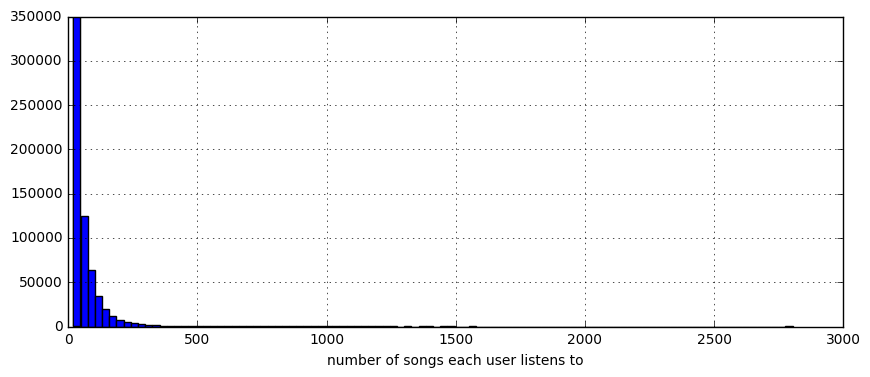

In [9]:
plt.figure(figsize=(10, 4))
usercount.hist(bins=100)
plt.xlabel('number of songs each user listens to')

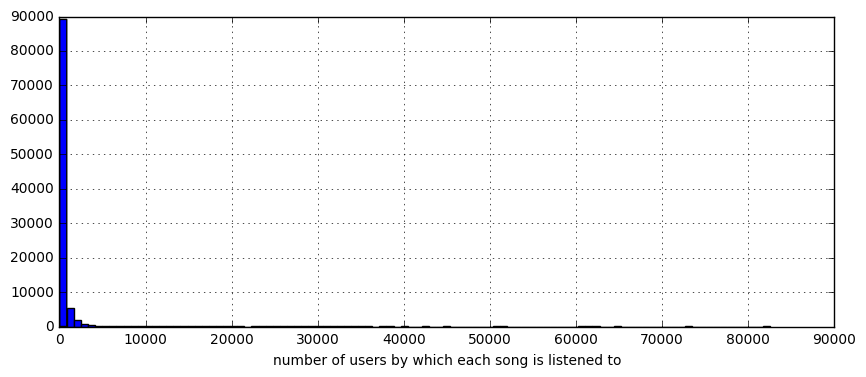

In [10]:
plt.figure(figsize=(10, 4))
songcount.hist(bins=100)
plt.xlabel('number of users by which each song is listened to')

In [11]:
# take a look at the top 50 most listened songs
def get_song_info_from_sid(conn, sid):
    cur = conn.cursor()
    cur.execute("SELECT title, artist_name FROM songs WHERE song_id = '%s'" % (sid))
    title, artist = cur.fetchone()
    return title, artist

songcount.sort(ascending=False)

with sqlite3.connect(md_dbfile) as conn:
    for i in xrange(50):
        sid = songcount.index[i]
        title, artist = get_song_info_from_sid(conn, sid)
        print "%s BY %s -- count: %d" % (title, artist, songcount[i])

/home/hadoop/datashdp/.linuxbrew/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


NameError: name 'md_dbfile' is not defined

You might wonder why "Sehr kosmisch" by Harmonia is the most popular song. There is actually a metadata matching error in the dataset that affects about 1% of the songs. But since collaborative filtering doesn't make use of metadata, this error will not affect us. Read more about it [here](http://labrosa.ee.columbia.edu/millionsong/blog/12-2-12-fixing-matching-errors).

## Subsample ~20000 songs and ~200000 users:

* First sample 250000 users based on listening count, only keep the data with those 250000 users
* Then sample 25000 songs from the pre-selected user listening history based on listening count
* Only keep the users who listened to at least 20 songs and the songs that are listened to by at least 50 users

In [12]:
unique_uid = usercount.index

np.random.seed(98765)

n_users = 250000
#n_users = 150000
p_users = usercount / usercount.sum()
idx = np.random.choice(len(unique_uid), size=n_users, replace=False, p=p_users.tolist())
unique_uid = unique_uid[idx]

In [13]:
tp = tp[tp['uid'].isin(unique_uid)]

In [14]:
unique_sid = songcount.index

n_songs = 25000
#n_songs = 15000
p_songs = songcount / songcount.sum()
idx = np.random.choice(len(unique_sid), size=n_songs, replace=False, p=p_songs.tolist())
unique_sid = unique_sid[idx]

In [15]:
tp = tp[tp['sid'].isin(unique_sid)]

In [16]:
tp, usercount, songcount = filter_triplets(tp, min_uc=MIN_USER_COUNT, min_sc=MIN_SONG_COUNT)
unique_uid = usercount.index
unique_sid = songcount.index

In [17]:
sparsity_level = float(tp.shape[0]) / (usercount.shape[0] * songcount.shape[0])
print "After subsampling and filtering, there are %d triplets from %d users and %d songs (sparsity level %.3f%%)" % \
(tp.shape[0], usercount.shape[0], songcount.shape[0], sparsity_level * 100)

After subsampling and filtering, there are 13964169 triplets from 211830 users and 22781 songs (sparsity level 0.289%)


In [19]:
song2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [20]:
with open(os.path.join(TPS_DIR, 'unique_uid_sub_{0}.txt'.format(MIN_USER_COUNT)), 'w') as f:
    for uid in unique_uid:
        f.write('%s\n' % uid)

In [21]:
with open(os.path.join(TPS_DIR, 'unique_sid_sub_{0}.txt'.format(MIN_SONG_COUNT)), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

## Generate train/test/vad sets

Pick out 20% of the rating for heldout test

In [22]:
np.random.seed(12345)
n_ratings = tp.shape[0]
test = np.random.choice(n_ratings, size=int(0.20 * n_ratings), replace=False)

In [23]:
test_idx = np.zeros(n_ratings, dtype=bool)
test_idx[test] = True

test_tp = tp[test_idx]
train_tp = tp[~test_idx]

Make sure there is no empty row or column in the training data

In [24]:
print "There are total of %d unique users in the training set and %d unique users in the entire dataset" % \
(len(pd.unique(train_tp['uid'])), len(pd.unique(tp['uid'])))

There are total of 211830 unique users in the training set and 211830 unique users in the entire dataset


In [25]:
print "There are total of %d unique items in the training set and %d unique items in the entire dataset" % \
(len(pd.unique(train_tp['sid'])), len(pd.unique(tp['sid'])))

There are total of 22781 unique items in the training set and 22781 unique items in the entire dataset


Pick out 10% of the training rating as validation set

In [26]:
np.random.seed(13579)
n_ratings = train_tp.shape[0]
vad = np.random.choice(n_ratings, size=int(0.10 * n_ratings), replace=False)

In [27]:
vad_idx = np.zeros(n_ratings, dtype=bool)
vad_idx[vad] = True

vad_tp = train_tp[vad_idx]
train_tp = train_tp[~vad_idx]

Again make sure there is no empty row or column in the training data

In [28]:
print "There are total of %d unique users in the training set and %d unique users in the entire dataset" % \
(len(pd.unique(train_tp['uid'])), len(pd.unique(tp['uid'])))

There are total of 211830 unique users in the training set and 211830 unique users in the entire dataset


In [29]:
print "There are total of %d unique items in the training set and %d unique items in the entire dataset" % \
(len(pd.unique(train_tp['sid'])), len(pd.unique(tp['sid'])))

There are total of 22781 unique items in the training set and 22781 unique items in the entire dataset


## Numerize the data into (user_index, item_index, count) format

In [30]:
def numerize(tp):
    uid = map(lambda x: user2id[x], tp['uid'])
    sid = map(lambda x: song2id[x], tp['sid'])
    tp['uid'] = uid
    tp['sid'] = sid
    return tp

In [31]:
train_tp = numerize(train_tp)
train_dir = 'train.num.sub.{0}.{1}.csv'.format(MIN_USER_COUNT, MIN_SONG_COUNT)
train_tp.to_csv(os.path.join(TPS_DIR, train_dir), index=False)

In [32]:
test_tp = numerize(test_tp)
test_dir = 'test.num.sub.{0}.{1}.csv'.format(MIN_USER_COUNT, MIN_SONG_COUNT)
test_tp.to_csv(os.path.join(TPS_DIR, test_dir), index=False)

/home/hadoop/datashdp/.linuxbrew/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/hadoop/datashdp/.linuxbrew/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
vad_tp = numerize(vad_tp)
vad_dir = 'vad.num.sub.{0}.{1}.csv'.format(MIN_USER_COUNT, MIN_SONG_COUNT)
vad_tp.to_csv(os.path.join(TPS_DIR, vad_dir), index=False)

In [33]:
TPS_DIR

'/home/net1/appry001/data/expo-mf-data'